<a href="https://colab.research.google.com/github/manoharsham/topic_model/blob/master/Doc2vec_Devo_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Topic Modeling in Python**

It's a method to extract hidden topics from a document/corpus and label certain parts of it. This helps to segment a document to certain topics for different users. It is helpful for summarization, improving customer support, SEO and many more.

## Setup the Environment

In [0]:
# Get code and data from GitHub repo
# This notebook is also part of the repo
!wget -q https://github.com/DevopediaOrg/related-articles/archive/master.zip

In [0]:
!unzip -oq master.zip

In [0]:
# Install necessary Python packages
!mv related-articles-master/* .
!rm -rf related-articles-master
!pip install -q -r requirements.txt

In [7]:
# Connect to Google Drive to save persistent data
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## Initializations

In [0]:
# Convert to command line arguments when porting to production script
NUM_OF_TRAIN = 400
NUM_OF_DEVOPEDIA_ARTICLES = 225
FULL_DEVO_TRAIN = True
ALPHA_STEP = 0.001
MIN_ALPHA = 0.000125
MAX_EPOCHS = 20
EMB_DIM = 50
DEBUG_LEVEL = 2
alpha = 0.025

## Read and Explore the Data

In [0]:
import libs.utils as utils

data = utils.read_json_file('/content/gdrive/My Drive/devodoc_full2.json')

In [0]:
# Convert lists to tuples
# We have a dict of lists of (strings or lists)
for k, v in data.items():
  if isinstance(v[0], list):
    for i, item in enumerate(v):
      v[i] = tuple(item)
  data[k] = tuple(v)

In [0]:
# Explore data to check for unexpected values
import pandas as pd

df = pd.DataFrame.from_dict(data, orient='index').transpose()

In [12]:
df.describe()

,title,text,related
count,517,517,517
unique,517,515,431
top,IP Tunnelling,"In signal processing, data compression, source...","(\n,)"
freq,1,2,47


In [13]:
df.head()

,title,text,related
0,MQTT,MQTT is a **publish/subscribe** messaging tran...,"(RabbitMQ, HiveMQ, Eclipse Mosquitto, Eclipse ..."
1,HTTP/2,HTTP/2 is an alternative to HTTP/1.x that has ...,"(HTTP/3, SPDY, HPACK, HTTP Pipelining, Domain ..."
2,Tensor Processing Unit,"![image](5335.1531331342.png ""TPU block diagra...","(AI Accelerator, Machine Learning, Deep Learni..."
3,Li-Fi,"Li-Fi, or Light Fidelity, uses light as a medi...","(Solar Li-Fi, Visible Light Communication, Lig..."
4,Race Condition (Software),Race condition in software is an undesirable e...,"(Race Condition (Hardware), Concurrent Computi..."


In [14]:
df.tail()

,title,text,related
512,Denial of Service,"In computing, a denial-of-service attack (DoS ...","(Application layer DDoS attack, BASHLITE, Bill..."
513,Data Analytics,Numerical analysis · Simulation\n Finite eleme...,"(Actuarial science, Analytics, Big data, Busin..."
514,Unified Modelling Language,The Unified Modeling Language (UML) is a gener...,"(Applications of UML, Business Process Model a..."
515,Modular Programming,Modular programming is a software design techn...,"(Architecture description language, Cohesion (..."
516,Dependency Hell,Dependency hell is a colloquial term for the f...,"(None, None, Dynamic dead code elimination, Pa..."


In [15]:
# Stats on text of articles
df['text'].apply(lambda x: len(x)).describe()

count      517.000000
mean     12742.305609
std      10718.301265
min         17.000000
25%       6531.000000
50%      10733.000000
75%      14999.000000
max      74889.000000
Name: text, dtype: float64

In [16]:
# How many articles have fewer than 1000 characters? 
# Will they be useful for training the model?
df['text'].apply(lambda x: len(x) < 1000).value_counts()

False    491
True      26
Name: text, dtype: int64

In [17]:
df[df['text'].apply(lambda x: len(x) < 1000)].tail()

,title,text,related
439,Angular,Angular may refer to:,"(Angle (disambiguation),)"
460,Grunt,"Grunt, grunts, or grunting may refer to:\n Man...","(Grund (disambiguation), None, Grunty (disambi..."
500,Apache OpenNLP,The Apache OpenNLP library is a machine learni...,"(\n,)"
507,VerbNet,The VerbNet project maps PropBank verb types t...,"(N, O, N, E)"
516,Dependency Hell,Dependency hell is a colloquial term for the f...,"(None, None, Dynamic dead code elimination, Pa..."


In [18]:
# Peek into a specific article and see if the content looks okay.
# https://en.wikipedia.org/wiki/Dependency_hell
df['text'][516]

'Dependency hell is a colloquial term for the frustration of some software users who have installed software packages which have dependencies on specific versions of other software packages.[1]\n The dependency issue arises around shared packages or libraries on which several other packages have dependencies but where they depend on different and incompatible versions of the shared packages. If the shared package or library can only be installed in a single version, the user may need to address the problem by obtaining newer or older versions of the dependent packages. This, in turn, may break other dependencies and push the problem to another set of packages.\n Dependency hell takes several forms:\n On specific computing platforms, "dependency hell" often goes by a local specific name, generally the name of components.'

In [19]:
# Stats on number of related articles per article
numrelated = df['related'].apply(lambda x: len(x))
numrelated.describe()

count    517.000000
mean       6.365571
std        5.304654
min        1.000000
25%        4.000000
50%        6.000000
75%        6.000000
max       42.000000
Name: related, dtype: float64

In [20]:
numrelated.value_counts().head(10)

6     201
1      64
4      60
2      31
5      25
3      21
7      19
8      15
10     14
9      10
Name: related, dtype: int64

In [21]:
max_related_idx = numrelated.idxmax()
print("Article with maximum related articles:", df['title'][max_related_idx], df['related'][max_related_idx])

Article with maximum related articles: Identity and Access Management ('Access control', 'Authentication', 'Authorization', 'Claims-based identity', 'Computer security', 'Digital card', 'Digital identity', 'Directory service', 'Dongle', 'Federated identity management', 'Hardware security module', 'Identity assurance', 'Identity driven networking', 'Identity management systems', 'Identity verification service', 'Identity provider', 'Identity-based security', 'Information privacy', 'Initiative For Open Authentication', 'List of single sign-on implementations', 'Loyalty card', 'Mobile identity management', 'Mobile signature', 'Multi-factor authentication', 'Mutual authentication', 'OAuth', 'Online identity management', 'OpenID', 'Password management', 'Personally Identifiable Information', 'Privileged identity management', 'RBAC', 'SAML 2.0', 'SAML-based products and services', 'Security token', 'Service provider', 'Single sign-on', 'Software token', 'Two-factor authentication', 'User mod

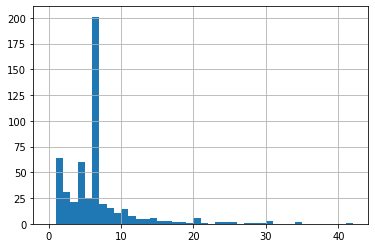

In [22]:
numrelated.hist(bins=range(numrelated.max()+1))

In [23]:
# Split the data for into train and test sets
from sklearn.model_selection import train_test_split

dtrain = {}
dtest ={}

if FULL_DEVO_TRAIN:
  dtrain['text'], dtest['text'] = \
    data['text'][:], data['text'][:NUM_OF_DEVOPEDIA_ARTICLES]
  dtrain['title'], dtest['title'] = \
    data['title'][:], data['title'][:NUM_OF_DEVOPEDIA_ARTICLES]
  dtrain['related'], dtest['related'] = \
    data['related'][:], data['related'][:NUM_OF_DEVOPEDIA_ARTICLES]

else:
  dtrain['text'], dtest['text'], \
  dtrain['title'], dtest['title'], \
  dtrain['related'], dtest['related'] = \
    train_test_split(
      data['text'], data['title'], data['related'],
      test_size=0.2, random_state=88)

print("Train set:", {k: len(v) for k, v in dtrain.items()})
print("Test set:", {k: len(v) for k, v in dtest.items()})

Train set: {'text': 517, 'title': 517, 'related': 517}
Test set: {'text': 225, 'title': 225, 'related': 225}


In [0]:
# Create aliases of the data
titles = dtrain['title']
doclist = dtrain['text']
related = dtrain['related']

## Data Preprocessing

In [25]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [0]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models.coherencemodel import CoherenceModel

In [0]:
contractions_dict = utils.read_json_file("data/contractions.json")

In [0]:
import os.path
import re
from string import punctuation

def preprocess_data(document):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # Create p_stemmer of class PorterStemmer
    #p_stemmer = PorterStemmer()

    # create lemmaizer for lemmatization
    lemmatizer = WordNetLemmatizer()

    # clean document string
    document = utils.expand_contractions(document.lower(), contractions_dict)
    document = re.sub(r"$\d+\W+|\b\d+\b|\W+\d+$", "", document)
    document = ''.join(c for c in document if c not in punctuation)
    document = document.lower().replace('(','').replace(')','')
    document = document.replace(',','').replace('.','').replace(':','').replace(';','')
    raw = document.lower()

    # tokenize document string and filter tokens
    #tokenizer = RegexpTokenizer(r'\w+')
    #tokens = tokenizer.tokenize(raw)
    tokens = word_tokenize(raw)
    en_stop = set(stopwords.words('english'))
    stopped_tokens = [i for i in tokens if not i in en_stop]
    lemma_tokens = [lemmatizer.lemmatize(i) for i in stopped_tokens]

    return tuple(lemma_tokens)

In [29]:
print(preprocess_data(doclist[300]))

('identity', 'management', 'idm', 'also', 'known', 'identity', 'access', 'management', 'iam', 'idam', 'framework', 'policy', 'technology', 'ensuring', 'proper', 'people', 'enterprise', 'appropriate', 'access', 'technology', 'resource', 'idm', 'system', 'fall', 'overarching', 'umbrella', 'security', 'data', 'management', 'identity', 'access', 'management', 'system', 'identify', 'authenticate', 'authorize', 'individual', 'utilizing', 'resource', 'also', 'hardware', 'application', 'employee', 'need', 'access', 'identity', 'access', 'management', 'solution', 'become', 'prevalent', 'critical', 'recent', 'year', 'regulatory', 'compliance', 'requirement', 'become', 'increasingly', 'rigorous', 'complex', 'address', 'need', 'ensure', 'appropriate', 'access', 'resource', 'across', 'increasingly', 'heterogeneous', 'technology', 'environment', 'meet', 'increasingly', 'rigorous', 'compliance', 'requirement', 'term', 'identity', 'management', 'idm', 'identity', 'access', 'management', 'used', 'inter

In [0]:
#tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(doclist)]
#tagged_data = [TaggedDocument(words=preprocess_data(_d), tags=[str(i)]) for i, _d in enumerate(doclist)]
#tagged_data[758]

In [0]:
ppdata = []
tagged_ppdata = []
for i, d in enumerate(data['text']):
  ppd = preprocess_data(d)
  ppdata.append(ppd)
  tagged_ppdata.append(TaggedDocument(words=ppd, tags=[str(i)]))

In [0]:
# Just checking if data is the way we expect
assert(ppdata[100] == tagged_ppdata[100][0])

## Modelling

In [0]:
model = Doc2Vec(vector_size=EMB_DIM,
                alpha=alpha,
                min_alpha=alpha,
                min_count=2,
                dm =0,dbow_words=1)

model.build_vocab(tagged_ppdata)

In [34]:
from tqdm.auto import tqdm
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity as cosim


ref_vec1=[]
ref_vec2=[]
for epoch in tqdm(range(MAX_EPOCHS), initial=1):
  model.train(tagged_ppdata,
              total_examples=model.corpus_count,
              epochs=epoch)

  if DEBUG_LEVEL:
    ref_vec1.append(model.docvecs[str(45)])
    ff1 = model.infer_vector(list(ppdata[45]))
    ref_vec2.append(model.docvecs[str(145)])
    ff2 = model.infer_vector(list(ppdata[145]))
    if epoch > 0:
      a = cosim([ref_vec1[epoch]], [ref_vec1[epoch-1]])[0][0]
      b = cosim([ff1], [ref_vec1[epoch]])[0][0]
      c = cosim([ref_vec2[epoch]], [ref_vec2[epoch-1]])[0][0]
      d = cosim([ff2], [ref_vec2[epoch]])[0][0]
      print("\tEpoch {:3d}: {:.6f} {:.6f} {:.6f} {:.6f} {:.6f}".format(epoch+1, a, b, c, d, model.alpha))

    # decrease the learning rate
    model.alpha -= ALPHA_STEP
    model.alpha = max(model.alpha, MIN_ALPHA)

    # fix the learning rate, no decay
    model.min_alpha = model.alpha
    
model.save("d2v.model")
print("Model Saved")

	Epoch   2: 1.000000 0.577890 1.000000 0.723764 0.024000
	Epoch   3: 1.000000 0.827778 1.000000 0.833031 0.023000
	Epoch   4: 1.000000 0.882078 1.000000 0.876121 0.022000
	Epoch   5: 1.000000 0.917649 1.000000 0.912755 0.021000
	Epoch   6: 1.000000 0.928678 1.000000 0.922432 0.020000
	Epoch   7: 1.000000 0.933217 1.000000 0.942423 0.019000
	Epoch   8: 1.000000 0.944194 1.000000 0.945647 0.018000
	Epoch   9: 1.000000 0.941000 1.000000 0.951122 0.017000
	Epoch  10: 1.000000 0.928458 1.000000 0.934595 0.016000
	Epoch  11: 1.000000 0.953677 1.000000 0.951513 0.015000
	Epoch  12: 1.000000 0.935677 1.000000 0.941420 0.014000
	Epoch  13: 1.000000 0.943695 1.000000 0.953524 0.013000
	Epoch  14: 1.000000 0.937931 1.000000 0.952964 0.012000
	Epoch  15: 1.000000 0.942269 1.000000 0.955001 0.011000
	Epoch  16: 1.000000 0.964205 1.000000 0.957744 0.010000
	Epoch  17: 1.000000 0.955349 1.000000 0.962699 0.009000
	Epoch  18: 1.000000 0.966003 1.000000 0.969594 0.008000
	Epoch  19: 1.000000 0.967890 1

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


## Prediction

In [35]:
# Load the saved model
model = Doc2Vec.load("d2v.model")
model.alpha = MIN_ALPHA

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [36]:
# Some initalizations
fields = ('ref doc', 'predicted see also', 'predicted metric', 'wiki see also', 'predicted metric for wiki', 'Success')
#fields = ('ref doc', 'predicted see also[JS]', 'predicted metric[JS]', 'predicted see also[HM]', 'predicted metric[HM]', 'wiki see also','predicted metric for wiki[JS]','predicted metric for wiki[HM]')
#fields = ('ref doc', 'predicted see also[JS]', 'predicted metric[JS]', 'predicted see also[HM]', 'predicted metric[HM]')

titles1_full=np.array(data['title'])
titles1_train=np.array(dtrain['title'])
titles1_test=np.array(dtest['title'])
print("Full/Train/Test:", len(titles1_full), len(titles1_train), len(titles1_test))

Full/Train/Test: 517 517 225


In [37]:
# Compute the distribution vectors for all data (wiki+devopedia)
docvecs=[]
docvecs2=[]
docnames=[]
for ref_id, _ in tqdm(enumerate(titles1_full), total=len(titles1_full), initial=1):
  docvecs2.append(model.docvecs[str(ref_id)])
  docvecs.append(model.infer_vector(list(ppdata[ref_id])))

  docnames.append(titles1_full[ref_id]) 
  
  if DEBUG_LEVEL == 2:
    v1 = model.docvecs[str(ref_id)]
    v2 = model.infer_vector(list(tagged_ppdata[ref_id][0]),alpha=MIN_ALPHA,min_alpha=MIN_ALPHA,epochs=100)
    v3 = model.infer_vector(list(ppdata[ref_id]),alpha=MIN_ALPHA,min_alpha=MIN_ALPHA,epochs=100)
    if ref_id % 25 == 0:
      a = cosim([v1],[v2])[0][0]
      b = cosim([v1],[v3])[0][0]
      c = cosim([v2],[v3])[0][0]
      print("\tref_id {:3d}: {:.6f} {:.6f} {:.6f}".format(ref_id, a, b, c))

	ref_id   0: 0.974320 0.974603 0.999934
	ref_id  25: 0.924106 0.923005 0.999934
	ref_id  50: 0.959277 0.958642 0.999930
	ref_id  75: 0.958384 0.958749 0.999943
	ref_id 100: 0.956289 0.956427 0.999940
	ref_id 125: 0.937670 0.937441 0.999927
	ref_id 150: 0.952073 0.952478 0.999925
	ref_id 175: 0.926611 0.926157 0.999893
	ref_id 200: 0.916870 0.916343 0.999923
	ref_id 225: 0.827555 0.829695 0.999856
	ref_id 250: 0.958197 0.958886 0.999932
	ref_id 275: 0.964828 0.964543 0.999935
	ref_id 300: 0.957829 0.957543 0.999913
	ref_id 325: 0.982142 0.982101 0.999934
	ref_id 350: 0.973836 0.974220 0.999916
	ref_id 375: 0.929544 0.929988 0.999932
	ref_id 400: 0.860222 0.861054 0.999834
	ref_id 425: 0.960681 0.961727 0.999926
	ref_id 450: 0.955891 0.957500 0.999929
	ref_id 475: 0.979215 0.979840 0.999930
	ref_id 500: 0.741150 0.742925 0.999618



In [38]:
# Compute the metric and dump the results based on the metric 
# Compute the see also for the wiki only data  
TOPK = 10
cos_sim2 = []
resultsDict = {}
for ref_id, _ in tqdm(enumerate(titles1_test), total=len(titles1_test), initial=1):
  cos_sim1 = []
  cos_sim2.append(cosim([docvecs[ref_id]], [docvecs2[ref_id]])[0][0])
  for docid, _ in enumerate(titles1_full):
    if docnames[docid] == docnames[ref_id]:
      cos_sim1.append(0)
      continue
    csim = cosim([docvecs[ref_id]], [docvecs[docid]])[0][0]
    cos_sim1.append(csim)

  cos_sim = np.array(cos_sim1)
  top5idx = np.argpartition(cos_sim, -TOPK)[-TOPK:]
  related1 = np.array(data['related'])
  resultsDict.setdefault(fields[0], []).append(titles1_full[ref_id])
  resultsDict.setdefault(fields[1], []).append(titles1_full[top5idx[:TOPK]])
  resultsDict.setdefault(fields[2], []).append(cos_sim[top5idx[:TOPK]])

  # Check the metric values for the see also present in the Dataset
  if ref_id > len(titles1_test):
    U = [S[2:] for S in related1[ref_id].split('\n')]
    U = U[1:-1]
    if '' in U:
      U = U[:U.index('')]
  else:
     U = related1[ref_id]   

  overlap_idx = []
  wikiseenames = []
  wikiseemetrics = []
  wikiseemetrics_hm = []

  for item in U:
    for idx, title in enumerate(data['title']):
      if item == title:
        overlap_idx.append(idx)
        wikiseenames.append(title)
        wikiseemetrics.append(cos_sim[idx])
          
  resultsDict.setdefault(fields[3], []).append(wikiseenames)
  resultsDict.setdefault(fields[4], []).append(wikiseemetrics)
  resultsDict.setdefault(fields[5], []).append(len([correct for correct in titles1_full[top5idx[:TOPK]] if correct in wikiseenames]))


In [39]:
import random

ref_id = random.randint(0,len(titles1_test));
v1 = model.docvecs[str(ref_id)]
v2 = model.infer_vector(list(tagged_ppdata[ref_id][0]))
v3 = model.infer_vector(list(ppdata[ref_id]))

a = cosim([v1],[v2])[0][0]
b = cosim([v1],[v3])[0][0]
c = cosim([v2],[v3])[0][0]
print("ref_id {:3d}: {:.6f} {:.6f} {:.6f}".format(ref_id, a, b, c))

ref_id 131: 0.967897 0.968158 0.998335


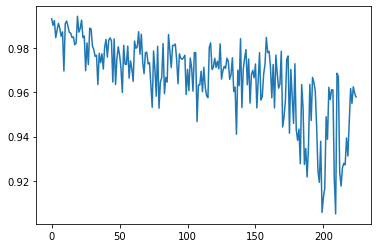

In [40]:
import matplotlib.pyplot as plt

plt.plot(cos_sim2)

In [0]:
dictlist = [{
    fields[0]: resultsDict[fields[0]][i],
    fields[1]: resultsDict[fields[1]][i],
    fields[2]: resultsDict[fields[2]][i],
    fields[3]: resultsDict[fields[3]][i],
    fields[4]: resultsDict[fields[4]][i],
    fields[5]: resultsDict[fields[5]][i]} for i, _ in enumerate(titles1_test)]

In [0]:
import csv

filename = '/content/gdrive/My Drive/results_Doc2Vec_fulltrain_embdim'+str(EMB_DIM)+'_TOP'+str(TOPK)+'.csv'
with open(filename, 'w') as csvfile:  
    writer = csv.DictWriter(csvfile, fieldnames = fields)  
    writer.writeheader()  
    for data in dictlist:
      writer.writerow(data)

Average number of correctly identified seel also [Doc2Vec] =  2.026666666666667


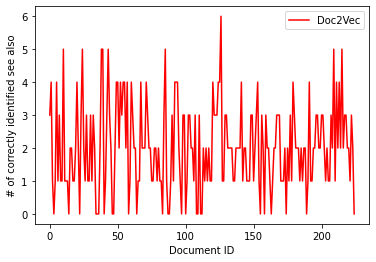

In [43]:
import pandas as pd 
# Read data from file 'filename.csv' 
# (in the same directory that your python process is based)
# Control delimiters, rows, column names with read_csv (see later) 

data1 = pd.read_csv(filename) 
print('Average number of correctly identified seel also [Doc2Vec] = ',
      data1['Success'].sum()/len(titles1_test))
Doc2vec_success=data1['Success']
plt.plot(Doc2vec_success,'r-',label='Doc2Vec')
plt.xlabel('Document ID')
plt.ylabel('# of correctly identified see also')
plt.legend()
plt.show()